In [4]:
import numpy as np # linear algebra
import random
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from pandas import datetime
import math, time
import itertools
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
import datetime
from operator import itemgetter
from sklearn.metrics import mean_squared_error
from math import sqrt
import torch
import torch.nn as nn
from torch.autograd import Variable

<ipython-input-4-a9ff8d01cf87>:5: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  from pandas import datetime


In [6]:
import os
for dirname, _, filenames in os.walk('data/'):
    for i, filename in enumerate(filenames):
        if i<5:
            print(os.path.join(dirname,filename))

data/ETFs\aadr.us.txt
data/ETFs\aaxj.us.txt
data/ETFs\acim.us.txt
data/ETFs\actx.us.txt
data/ETFs\acwf.us.txt
data/Stocks\a.us.txt
data/Stocks\aa.us.txt
data/Stocks\aaap.us.txt
data/Stocks\aaba.us.txt
data/Stocks\aac.us.txt


In [7]:
symbols = ['aapl','goog','ibm']

In [8]:
def stocks_data(symbols, dates):
    df = pd.DataFrame(index=dates)
    for symbol in symbols:
        df_temp = pd.read_csv("data/Stocks/{}.us.txt".format(symbol), index_col='Date',
                parse_dates=True, usecols=['Date', 'Close'], na_values=['nan'])
        df_temp = df_temp.rename(columns={'Close': symbol})
        df = df.join(df_temp)
    return df

              goog     ibm    aapl
2015-01-02  524.81  145.54  103.50
2015-01-05  513.87  143.24  100.58
2015-01-06  501.96  140.14  100.59
2015-01-07  501.10  139.23  102.01
2015-01-08  502.68  142.26  105.93
...            ...     ...     ...
2016-12-26     NaN     NaN     NaN
2016-12-27  791.55  160.90  115.41
2016-12-28  785.05  159.98  114.92
2016-12-29  782.79  160.38  114.89
2016-12-30  771.82  159.79  113.99

[521 rows x 3 columns]


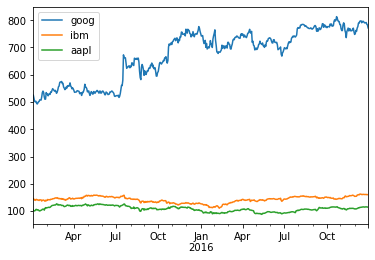

In [10]:
dates = pd.date_range('2015-01-02','2016-12-31',freq='B')
symbols = ['goog','ibm','aapl']
df = stocks_data(symbols, dates)
df.fillna(method='pad')
print(df)
df.interpolate().plot()
plt.show()

In [11]:
df.head()

,goog,ibm,aapl
2015-01-02,524.81,145.54,103.50
2015-01-05,513.87,143.24,100.58
2015-01-06,501.96,140.14,100.59
2015-01-07,501.10,139.23,102.01
2015-01-08,502.68,142.26,105.93


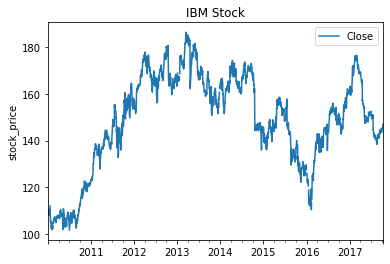

In [12]:
dates = pd.date_range('2010-01-02','2017-10-11',freq='B')
df1=pd.DataFrame(index=dates)
df_ibm=pd.read_csv("data/Stocks/ibm.us.txt", parse_dates=True, index_col=0)
df_ibm=df1.join(df_ibm)
df_ibm[['Close']].plot()
plt.ylabel("stock_price")
plt.title("IBM Stock")
plt.show()

In [14]:
df_ibm=df_ibm[['Close']]
df_ibm.head()

,Close
2010-01-04,110.59
2010-01-05,109.26
2010-01-06,108.56
2010-01-07,108.19
2010-01-08,109.26


In [21]:
df_ibm=df_ibm.fillna(method='ffill')

scaler = MinMaxScaler(feature_range=(-1, 1))
df_ibm['Close'] = scaler.fit_transform(df_ibm['Close'].values.reshape(-1,1))

In [22]:
df_ibm

,Close
2010-01-04,-0.790830
2010-01-05,-0.822264
2010-01-06,-0.838809
2010-01-07,-0.847554
2010-01-08,-0.822264
...,...
2017-10-05,0.028835
2017-10-06,0.023162
2017-10-09,0.044434
2017-10-10,0.070433


In [44]:
def load_data(stock,look_back):
    data_raw = stock.values
    data = []
    for index in range(len(data_raw) - look_back): 
        data.append(data_raw[index: index + look_back])
    data = np.array(data)
    test_set_size = int(np.round(0.2*data.shape[0]))
    train_set_size = data.shape[0] - (test_set_size) 
    x_train = data[:train_set_size,:-1,:] #(1606,19,1)
    y_train = data[:train_set_size,-1,:]
    x_test  = data[train_set_size:,:-1,:]
    y_test  = data[train_set_size:,-1,:]
    return [x_train,y_train,x_test,y_test]

In [45]:
look_back = 20 # choose sequence length
x_train, y_train, x_test, y_test = load_data(df_ibm, look_back)
print('x_train.shape = ',x_train.shape)
print('y_train.shape = ',y_train.shape)
print('x_test.shape = ',x_test.shape)
print('y_test.shape = ',y_test.shape)

x_train.shape =  (1606, 19, 1)
y_train.shape =  (1606, 1)
x_test.shape =  (402, 19, 1)
y_test.shape =  (402, 1)


In [46]:
# make training and test sets in torch
x_train = torch.from_numpy(x_train).type(torch.Tensor)
x_test = torch.from_numpy(x_test).type(torch.Tensor)
y_train = torch.from_numpy(y_train).type(torch.Tensor)
y_test = torch.from_numpy(y_test).type(torch.Tensor)

In [47]:
y_train.size(),x_train.size()

(torch.Size([1606, 1]), torch.Size([1606, 19, 1]))

In [48]:
n_steps = look_back-1
batch_size = 1606
num_epochs = 100

In [51]:
train = torch.utils.data.TensorDataset(x_train,y_train)
test = torch.utils.data.TensorDataset(x_test,y_test)
train_loader = torch.utils.data.DataLoader(dataset=train, 
                                           batch_size=batch_size, 
                                           shuffle=False)

test_loader = torch.utils.data.DataLoader(dataset=test, 
                                          batch_size=batch_size, 
                                          shuffle=False)

In [53]:
# Build model
#####################
input_dim = 1
hidden_dim = 32
num_layers = 2 
output_dim = 1
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTM, self).__init__()
        # Hidden dimensions
        self.hidden_dim = hidden_dim

        # Number of hidden layers
        self.num_layers = num_layers

        # Building your LSTM
        # batch_first=True causes input/output tensors to be of shape
        # (batch_dim, seq_dim, feature_dim)
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)

        # Readout layer
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # Initialize hidden state with zeros
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()

        # Initialize cell state
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()

        # One time step
        # We need to detach as we are doing truncated backpropagation through time (BPTT)
        # If we don't, we'll backprop all the way to the start even after going through another batch
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))

        out = self.fc(out[:, -1, :]) 
        # out.size() --> 100, 10
        return out
    

In [56]:
model = LSTM(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)

loss_fn = torch.nn.MSELoss(size_average=True)

optimiser = torch.optim.Adam(model.parameters(), lr=0.01)
print(model)
print(len(list(model.parameters())))
for i in range(len(list(model.parameters()))):
    print(list(model.parameters())[i].size())

LSTM(
  (lstm): LSTM(1, 32, num_layers=2, batch_first=True)
  (fc): Linear(in_features=32, out_features=1, bias=True)
)
10
torch.Size([128, 1])
torch.Size([128, 32])
torch.Size([128])
torch.Size([128])
torch.Size([128, 32])
torch.Size([128, 32])
torch.Size([128])
torch.Size([128])
torch.Size([1, 32])
torch.Size([1])


In [57]:
# train model
hist = np.zeros(num_epochs)
seq_dim = look_back-1
for t in range(num_epochs):
    # Initialise hidden state
    # Don't do this if you want your LSTM to be stateful
    #model.hidden = model.init_hidden()
    
    # Forward pass
    y_train_pred = model(x_train)

    loss = loss_fn(y_train_pred, y_train)
    if t % 10 == 0 and t !=0:
        print("Epoch ", t, "MSE: ", loss.item())
    hist[t] = loss.item()

    # Zero out gradient, else they will accumulate between epochs
    optimiser.zero_grad()

    # Backward pass
    loss.backward()

    # Update parameters
    optimiser.step()

Epoch  10 MSE:  0.024474257603287697
Epoch  20 MSE:  0.017615579068660736
Epoch  30 MSE:  0.008524168282747269
Epoch  40 MSE:  0.00641922140493989
Epoch  50 MSE:  0.005294466856867075
Epoch  60 MSE:  0.004489664454013109
Epoch  70 MSE:  0.004149958956986666
Epoch  80 MSE:  0.003969894256442785
Epoch  90 MSE:  0.0037782469298690557


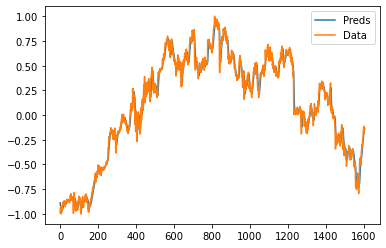

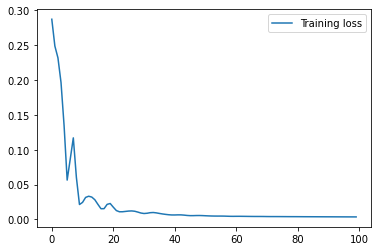

In [58]:
plt.plot(y_train_pred.detach().numpy(), label="Preds")
plt.plot(y_train.detach().numpy(), label="Data")
plt.legend()
plt.show()

plt.plot(hist, label="Training loss")
plt.legend()
plt.show()

In [61]:
# make predictions
y_test_pred = model(x_test)

# invert predictions
y_train_pred = scaler.inverse_transform(y_train_pred.detach().numpy())
y_train = scaler.inverse_transform(y_train.detach().numpy())
y_test_pred = scaler.inverse_transform(y_test_pred.detach().numpy())
y_test = scaler.inverse_transform(y_test.detach().numpy())

# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(y_train[:,0], y_train_pred[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(y_test[:,0], y_test_pred[:,0]))
print('Test Score: %.2f RMSE' % (testScore))


AttributeError: 'numpy.ndarray' object has no attribute 'detach'

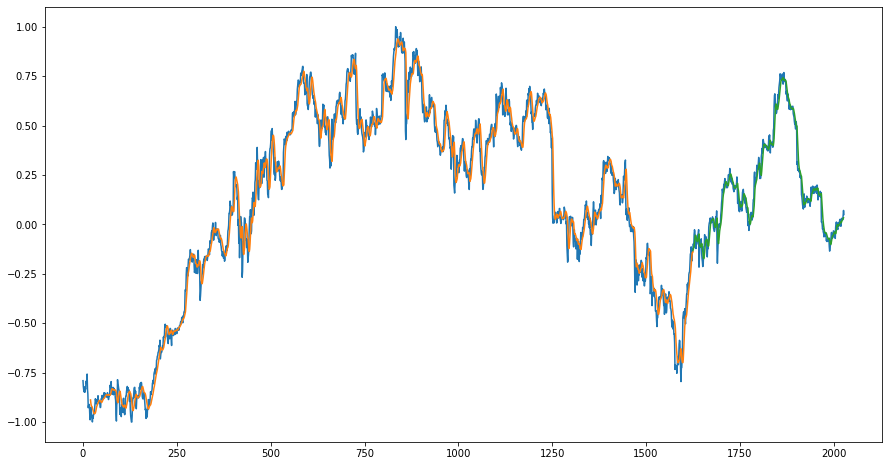

In [60]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(df_ibm)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(y_train_pred)+look_back, :] = y_train_pred

# shift test predictions for plotting
testPredictPlot = np.empty_like(df_ibm)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(y_train_pred)+look_back-1:len(df_ibm)-1, :] = y_test_pred

# plot baseline and predictions
plt.figure(figsize=(15,8))
plt.plot(scaler.inverse_transform(df_ibm))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [62]:
y_test

array([[-0.11888442],
       [-0.09832191],
       [-0.11864807],
       [-0.05128811],
       [-0.02741669],
       [-0.03734342],
       [-0.08319546],
       [-0.08272276],
       [-0.12219334],
       [-0.09784921],
       [-0.10021272],
       [-0.09170409],
       [-0.05625148],
       [-0.05743323],
       [-0.0456157 ],
       [-0.02718034],
       [-0.21649729],
       [-0.16969983],
       [-0.09903096],
       [-0.11652092],
       [-0.10966674],
       [-0.10375798],
       [-0.07326873],
       [-0.14842826],
       [-0.1732451 ],
       [-0.18813519],
       [-0.21342473],
       [-0.21058851],
       [-0.16142756],
       [-0.11203025],
       [-0.1108485 ],
       [-0.05199716],
       [-0.07492319],
       [-0.07728669],
       [-0.10233987],
       [-0.063342  ],
       [-0.09619475],
       [-0.1108485 ],
       [-0.16473646],
       [-0.1127393 ],
       [-0.12361144],
       [-0.08910423],
       [-0.01347199],
       [ 0.00307256],
       [ 0.01229024],
       [ 0